<a href="https://colab.research.google.com/github/mraihanramadhan/Machine-Learning/blob/main/Week6_Comparing%20different%20clustering%20algorithms%20on%20toy%20datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Automatically created module for IPython interactive environment


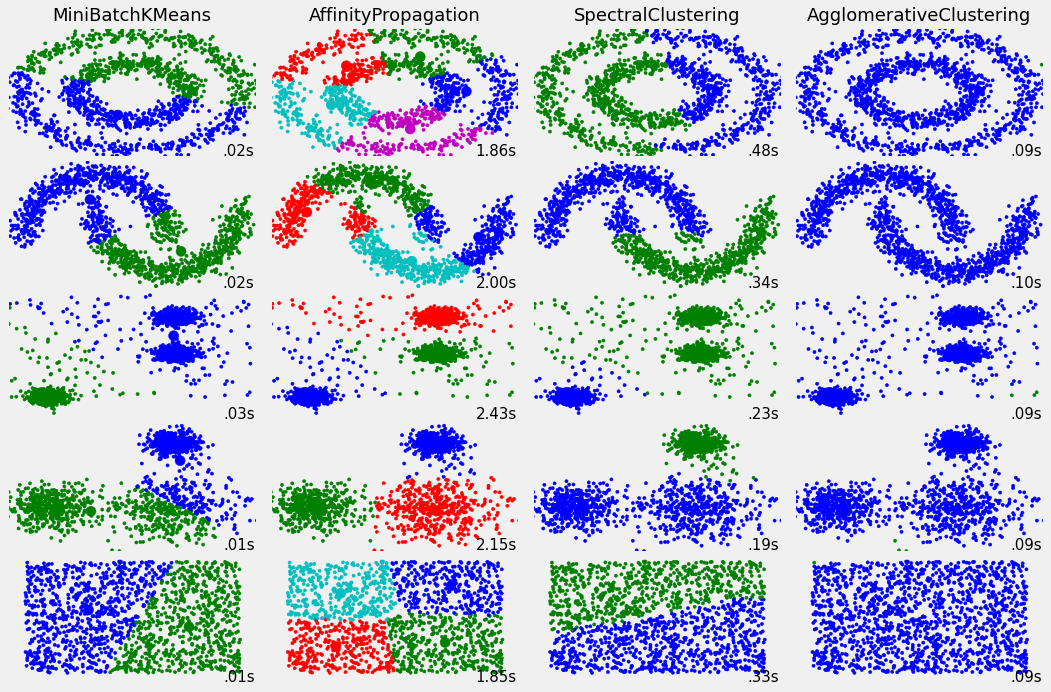

In [9]:
print(__doc__)

import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

np.random.seed(0)
plt.style.use('fivethirtyeight')

def make_var_density_blobs(n_samples=750, centers=[[0,0]], cluster_std=[0.5], random_state=0):
    samples_per_blob = n_samples // len(centers)
    blobs = [datasets.make_blobs(n_samples=samples_per_blob, centers=[c], cluster_std=cluster_std[i])[0]
             for i, c in enumerate(centers)]
    labels = [i * np.ones(samples_per_blob) for i in range(len(centers))]
    return np.vstack(blobs), np.hstack(labels)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.08)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.10)
blobs = datasets.make_blobs(n_samples=n_samples-200, random_state=8)
noisy_blobs = np.vstack((blobs[0], 25.0*np.random.rand(200, 2)-[10.0,10.0])), np.hstack((blobs[1], -1*np.ones(200))) 
varying_blobs = make_var_density_blobs(n_samples,
                                       centers=[[1, 1],
                                                [-1, -1],
                                                [1, -1]],
                                       cluster_std=[0.2, 0.35, 0.5])
no_structure = np.random.rand(n_samples, 2), None

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'MiniBatchKMeans', 'AffinityPropagation',
    'SpectralClustering', 'AgglomerativeClustering',
    'DBSCAN', 'HDBSCAN']

plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

datasets = [noisy_circles, noisy_moons, noisy_blobs, varying_blobs, no_structure]
for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    two_means = cluster.MiniBatchKMeans(n_clusters=2)
    spectral = cluster.SpectralClustering(n_clusters=2,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=.2)
    affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)

    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=2,
        connectivity=connectivity)

    clustering_algorithms = [
        two_means, affinity_propagation, spectral, average_linkage]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(5, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()